In [23]:
!python3 -m pip show fastai

Name: fastai
Version: 2.7.12
Summary: fastai simplifies training fast and accurate neural nets using modern best practices
Home-page: https://github.com/fastai/fastai
Author: Jeremy Howard, Sylvain Gugger, and contributors
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /Users/cuongwilliams/miniconda3/envs/seemap2023/lib/python3.8/site-packages
Requires: fastcore, fastdownload, fastprogress, matplotlib, packaging, pandas, pillow, pip, pyyaml, requests, scikit-learn, scipy, spacy, torch, torchvision
Required-by: 


In [34]:
import torch
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())
torch.device("mps")

from fastai.vision.all import *
default_device(torch.device("mps"))


from timm import create_model

True
True


ModuleNotFoundError: No module named 'timm'

In [25]:
print(dir(URLs))

['ADULT_SAMPLE', 'AG_NEWS', 'AMAZON_REVIEWS', 'AMAZON_REVIEWS_POLARITY', 'BIWI_HEAD_POSE', 'BIWI_SAMPLE', 'CALTECH_101', 'CAMVID', 'CAMVID_TINY', 'CARS', 'CIFAR', 'CIFAR_100', 'COCO_SAMPLE', 'COCO_TINY', 'CUB_200_2011', 'DBPEDIA', 'DOGS', 'FLOWERS', 'FOOD', 'GOOGLE', 'HUMAN_NUMBERS', 'IMAGENETTE', 'IMAGENETTE_160', 'IMAGENETTE_320', 'IMAGEWANG', 'IMAGEWANG_160', 'IMAGEWANG_320', 'IMAGEWOOF', 'IMAGEWOOF_160', 'IMAGEWOOF_320', 'IMDB', 'IMDB_SAMPLE', 'LOCAL_PATH', 'LSUN_BEDROOMS', 'MACAQUES', 'MDL', 'ML_100k', 'ML_SAMPLE', 'MNIST', 'MNIST_SAMPLE', 'MNIST_TINY', 'MNIST_VAR_SIZE_TINY', 'MT_ENG_FRA', 'OPENAI_TRANSFORMER', 'PASCAL_2007', 'PASCAL_2012', 'PETS', 'PLANET_SAMPLE', 'PLANET_TINY', 'S3', 'S3_AUDI', 'S3_COCO', 'S3_IMAGE', 'S3_IMAGELOC', 'S3_MODEL', 'S3_NLP', 'SIIM_SMALL', 'SOGOU_NEWS', 'TCGA_SMALL', 'URL', 'WIKITEXT', 'WIKITEXT_TINY', 'WT103_BWD', 'WT103_FWD', 'YAHOO_ANSWERS', 'YELP_REVIEWS', 'YELP_REVIEWS_POLARITY', 'ZEBRA_FINCH', '__class__', '__delattr__', '__dict__', '__dir__', '

In [26]:
path = untar_data(URLs.MNIST)
print(path)

/Users/cuongwilliams/.fastai/data/mnist_png


In [27]:
block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label)
#        batch_tfms=aug_transforms(mult=2., do_flip=False))

In [28]:
loaders = block.dataloaders(path/"training")
#loaders.train.show_batch(max_n=4, nrows=1)

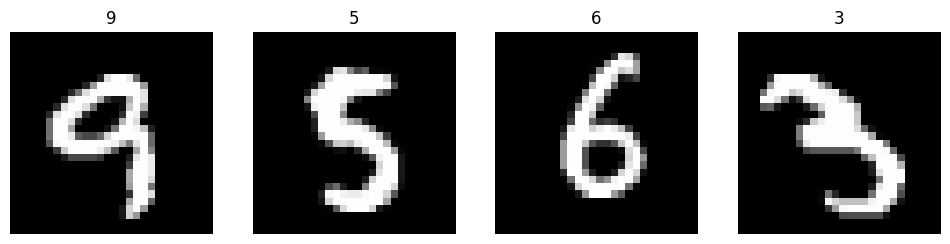

In [29]:
loaders.train.show_batch(max_n=4, nrows=1)

In [32]:
learn = vision_learner(loaders, squeezenet1_0, metrics=accuracy)

/Users/cuongwilliams/miniconda3/envs/seemap2023/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /Users/cuongwilliams/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

In [33]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.608568,inf,0.866250,00:35
